#Team Details :
## CS23MTECH11020 - Suryansh Gautam
## CS23MTECH11008 - V Harikrishnan
## CS23MTECH11029 - Patel Heetkumar D.
## CS23MTECH13001 - Anil kumar Sharma
## CS23MTECH13002 - KR Anuraj


Mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing necessary library

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00


Importing necessary libraries

In [ ]:
import networkx as nx
import random
import pandas as pd
import numpy as np
from tensorflow.keras import Model, optimizers, losses
from sklearn import preprocessing, model_selection
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

Reading dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Payments.csv')

Creating directional graph

In [ ]:
G = nx.DiGraph()

for index, row in df.iterrows():
    sender = row['Sender']
    receiver = row['Receiver']
    amount = row['Amount']
    if G.has_edge(sender, receiver):
        G[sender][receiver]['weight'] += np.log(amount)
    else:
        G.add_edge(sender, receiver, weight=np.log(amount))

In [ ]:
n = len(G.nodes())

Generating edge list and corresponding weight list

In [ ]:
mapping = {node: i for i, node in enumerate(G.nodes)}
G = nx.relabel_nodes(G, mapping)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
edge_weight = torch.tensor([G[u][v]['weight'] for u, v in G.edges], dtype=torch.float)

In [ ]:
edge_weight.shape

torch.Size([5358])

Graph convolutional network model

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_nodes, embed_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_nodes, 128)
        self.conv2 = GCNConv(128, embed_dim)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x


Calculating pairwise loss

In [ ]:
def distance_loss(embeddings):
    dist_matrix = torch.cdist(embeddings, embeddings, p=2)
    mean_dist = torch.mean(dist_matrix)
    return mean_dist

Training GCN model

In [ ]:
model = GCN(n, embed_dim=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
features = torch.eye(n)
x = torch.tensor(features, dtype=torch.float)

model.train()
for epoch in range(100):

    out = model(x, edge_index, edge_weight)
    loss = distance_loss(out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

<ipython-input-70-d60d1d3c71d2>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(features, dtype=torch.float)


Fetching embeddings from model

In [ ]:
with torch.no_grad():
    model.eval()
    embeddings = model(x, edge_index, edge_weight).detach().numpy()
embeddings.shape

(799, 5)

Training K means using generated embeddings

In [ ]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(embeddings)
labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training PCA using generated embeddings

In [ ]:
pca = PCA(n_components=2)
dim_2 = pca.fit_transform(embeddings)

Plotting the clusters that are generated using GCN method

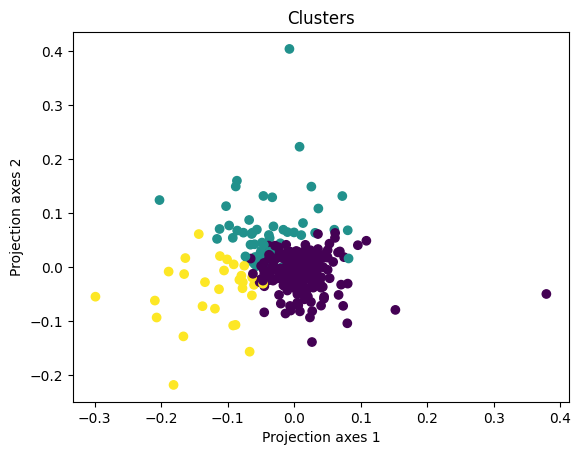

In [ ]:
plt.scatter(dim_2[:, 0], dim_2[:, 1], c=labels, cmap='viridis')
plt.title('Clusters')
plt.xlabel('Projection axes 1')
plt.ylabel('Projection axes 2')
plt.show()